In [ ]:
# %pip install ramanspy

In [2]:
# %pip install scikit-image

In [3]:
import skimage as sk


In [4]:
import ramanspy as rp
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt


In [5]:
import torch
from torch import nn


class BasicConv(nn.Module):
    def __init__(self, channels_in, channels_out, batch_norm):
        super(BasicConv, self).__init__()
        basic_conv = [nn.Conv1d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=True)]
        basic_conv.append(nn.PReLU())
        if batch_norm:
            basic_conv.append(nn.BatchNorm1d(channels_out))

        self.body = nn.Sequential(*basic_conv)

    def forward(self, x):
        return self.body(x)


class ResUNetConv(nn.Module):
    def __init__(self, num_convs, channels, batch_norm):
        super(ResUNetConv, self).__init__()
        unet_conv = []
        for _ in range(num_convs):
            unet_conv.append(nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=1, bias=True))
            unet_conv.append(nn.PReLU())
            if batch_norm:
                unet_conv.append(nn.BatchNorm1d(channels))

        self.body = nn.Sequential(*unet_conv)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


class UNetLinear(nn.Module):
    def __init__(self, repeats, channels_in, channels_out):
        super().__init__()
        modules = []
        for i in range(repeats):
            modules.append(nn.Linear(channels_in, channels_out))
            modules.append(nn.PReLU())

        self.body = nn.Sequential(*modules)

    def forward(self, x):
        x = self.body(x)
        return x


class ResUNet(nn.Module):
    def __init__(self, num_convs, batch_norm):
        super(ResUNet, self).__init__()
        res_conv1 = [BasicConv(1, 64, batch_norm)]
        res_conv1.append(ResUNetConv(num_convs, 64, batch_norm))
        self.conv1 = nn.Sequential(*res_conv1)
        self.pool1 = nn.MaxPool1d(2)

        res_conv2 = [BasicConv(64, 128, batch_norm)]
        res_conv2.append(ResUNetConv(num_convs, 128, batch_norm))
        self.conv2 = nn.Sequential(*res_conv2)
        self.pool2 = nn.MaxPool1d(2)

        res_conv3 = [BasicConv(128, 256, batch_norm)]
        res_conv3.append(ResUNetConv(num_convs, 256, batch_norm))
        res_conv3.append(BasicConv(256, 128, batch_norm))
        self.conv3 = nn.Sequential(*res_conv3)
        self.up3 = nn.Upsample(scale_factor=2)

        res_conv4 = [BasicConv(256, 128, batch_norm)]
        res_conv4.append(ResUNetConv(num_convs, 128, batch_norm))
        res_conv4.append(BasicConv(128, 64, batch_norm))
        self.conv4 = nn.Sequential(*res_conv4)
        self.up4 = nn.Upsample(scale_factor=2)

        res_conv5 = [BasicConv(128, 64, batch_norm)]
        res_conv5.append(ResUNetConv(num_convs, 64, batch_norm))
        self.conv5 = nn.Sequential(*res_conv5)
        res_conv6 = [BasicConv(64, 1, batch_norm)]
        self.conv6 = nn.Sequential(*res_conv6)

        self.linear7 = UNetLinear(3, 500, 500)

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.pool1(x)

        x2 = self.conv2(x1)
        x3 = self.pool1(x2)

        x3 = self.conv3(x3)
        x3 = self.up3(x3)

        x4 = torch.cat((x2, x3), dim=1)
        x4 = self.conv4(x4)
        x5 = self.up4(x4)

        x6 = torch.cat((x, x5), dim=1)
        x6 = self.conv5(x6)
        x7 = self.conv6(x6)

        out = self.linear7(x7)

        return out


net = ResUNet(3, False).float()
net.load_state_dict(torch.load(r"ResUNet.pt", map_location=torch.device('cpu')))


def nn_preprocesing(spectral_data, wavenumber_axis):
    flat_spectral_data = spectral_data.reshape(-1, spectral_data.shape[-1])

    output = net(torch.Tensor(flat_spectral_data).unsqueeze(1)).cpu().detach().numpy()
    output = np.squeeze(output)

    output = output.reshape(spectral_data.shape)

    return output, wavenumber_axis


nn_denoiser = rp.preprocessing.PreprocessingStep(nn_preprocesing)

baseliners = {
    'SG (2, 5)': rp.preprocessing.denoise.SavGol(window_length=5, polyorder=2),
    'SG (2, 7)': rp.preprocessing.denoise.SavGol(window_length=7, polyorder=2),
    'SG (2, 9)': rp.preprocessing.denoise.SavGol(window_length=9, polyorder=2),
    'SG (3, 5)': rp.preprocessing.denoise.SavGol(window_length=5, polyorder=3),
    'SG (3, 7)': rp.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
    'SG (3, 9)': rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
}

minmax = rp.preprocessing.normalise.MinMax()

def get_results(spectrum_to_denoise, target, denoiser):
    # Normalise input and output to 0-1
    spectrum_to_denoise = minmax.apply(spectrum_to_denoise)
    target = minmax.apply(target)

    output = denoiser.apply(spectrum_to_denoise)

    metrics_result = {metric: getattr(rp.metrics, metric)(output, target) for metric in METRICS}

    return output, metrics_result


def show_results(nn_results_df, baseline_results_dfs):
    for metric in METRICS:
        plt.figure(figsize=(4, 6), tight_layout=True)

        bar_kwargs = {'linewidth': 2, 'zorder': 5}
        err_kwargs = {'zorder': 0, 'fmt': 'none', 'linewidth': 2, 'ecolor': 'k', 'capsize': 5}

        combined_df = pd.concat([nn_results_df[metric], *[df[metric] for df in baseline_results_dfs.values()]], axis=1,
                                ignore_index=True)
        combined_df.columns = ['NN'] + list(baseline_results_dfs.keys())

        # Plot
        means = combined_df.mean()
        stds = combined_df.std()
        labels = combined_df.columns

        sg_cmap = LinearSegmentedColormap.from_list('', [colors[1], [1, 1, 1, 1]])
        colors_to_use = list(sg_cmap(np.linspace(0, 1, len(baseliners.keys()) + 2)))[:-2]

        ax = plt.gca()
        ax.bar(labels, means, color=[colors[3]] + colors_to_use[::-1], **bar_kwargs)
        ax.errorbar(labels, means, yerr=[[0] * len(stds), stds], **err_kwargs)

        # Significance tests
        combined_df_ = combined_df.melt(var_name='Denoiser', value_name=metric)
        box_pairs = [('NN', base) for base in baseliners.keys()]
        annotator = Annotator(ax, box_pairs, data=combined_df_, x="Denoiser", y=metric)
        annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction='fdr_bh')
        annotator.apply_and_annotate()

        ax.set_title(metric)
        plt.xticks(rotation=45, ha='right')
        plt.show()


def add_normal_noise(spectrum, std=0.15):
    spectrum = rp.preprocessing.normalise.MinMax().apply(spectrum)

    # add noise
    noise = np.random.normal(0, std, len(spectrum.spectral_data))
    noisy_spectrum = rp.Spectrum(spectrum.spectral_data + noise, spectrum.spectral_axis)

    return noisy_spectrum


target_spectrum = pd.read_csv(r"C:\Users\charl\Documents\Python dev\Raman_peak_matching\ForCharlotte\04 JLG007_magnetite_100X_2sx2.txt", 
                              sep='\s+', header=None,names= ["Wavenumber", "Intensity"])

def witec_headless_to_rp(filename):
    data = pd.read_csv(filename,sep='\s+', header=None,names= ["Wavenumber", "Intensity"])
    # parse and load data into spectral objects
    spectral_data = data["Intensity"]
    spectral_axis = data["Wavenumber"]
    raman_spectrum = rp.Spectrum(spectral_data, spectral_axis)

    return raman_spectrum

target_spec=witec_headless_to_rp(r"C:\Users\charl\Documents\Python dev\Raman_peak_matching\ForCharlotte\04 JLG007_magnetite_100X_2sx2.txt")

preprocessing_pipeline = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(80, 3000)),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])

target_spec_preprocessed = preprocessing_pipeline.apply(target_spec)
rp.plot.spectra(target_spec_preprocessed,plot_type='separate')


selected_target=target_spec_preprocessed 
selected_input = add_normal_noise(selected_target)

rp.plot.spectra([selected_input,selected_target],plot_type='single')
nn_results = get_results(selected_input, selected_target, nn_denoiser)

FileNotFoundError: [Errno 2] No such file or directory: 'ResUNet.pt'

In [29]:
selected_target=target_spec_preprocessed 
selected_input = add_normal_noise(selected_target)

nn_results = get_results(selected_input, selected_target, nn_denoiser)[0]
baseline_results = get_results(selected_input, selected_target, baseliners['SG (3, 9)'])[0]

results = minmax.apply([selected_input, baseline_results, selected_target, nn_results])
labels = ['Input (data with noise)', 'Savitzky-Golay (3, 9)', 'Target (authentic data)', 'Neural network']

plt.figure(figsize=(10, 4), tight_layout=True)
ax = rp.plot.spectra(results, plot_type='single', ylabel='Normalised intensity', title='Transfer dataset', color=colors)
ax.legend(labels)

plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 351 but got size 350 for tensor number 1 in the list.

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

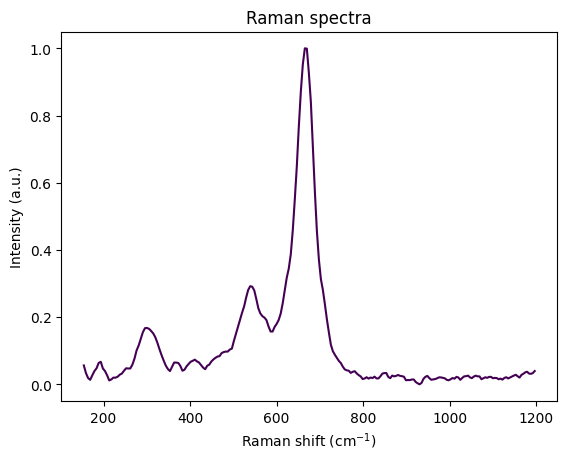

In [11]:
local_rruff=rp.datasets.rruff(r"C:\Users\charl\Documents\Python dev\Raman_peak_matching\RRUFF_Raman_532", download=False)
local_rruff_pp=(preprocessing_pipeline.apply(local_rruff[0]),local_rruff[1].copy())

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

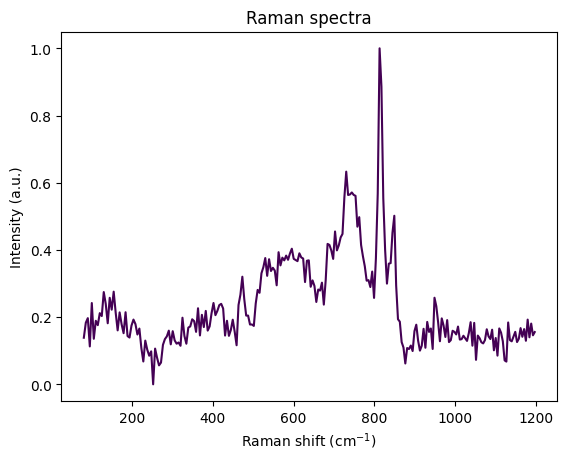

In [9]:
# target_spectrum = pd.read_csv(r"C:\Users\charl\Documents\Python dev\Raman_peak_matching\ForCharlotte\04 JLG007_magnetite_100X_2sx2.txt", 
#                               sep='\s+', header=None,names= ["Wavenumber", "Intensity"])
import ramanspy as rp
import pandas as pd
import numpy as np
import os 

def witec_headless_to_rp(filename):
    data = pd.read_csv(filename,sep='\s+', header=None,names= ["Wavenumber", "Intensity"])
    # parse and load data into spectral objects
    spectral_data = data["Intensity"]
    spectral_axis = data["Wavenumber"]
    raman_spectrum = rp.Spectrum(spectral_data, spectral_axis)

    return raman_spectrum

target_spec=witec_headless_to_rp(r"C:\Users\charl\Documents\Python dev\raman-peak-id\Files\01 NRAIN01-3_inclusion_300g.txt")
preprocessing_pipeline = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(80, 1200)),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.baseline.IARPLS(),
    rp.preprocessing.normalise.MinMax(pixelwise=False),
])

target_spec_preprocessed = preprocessing_pipeline.apply(target_spec)
rp.plot.spectra(target_spec_preprocessed,plot_type='separate')



<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

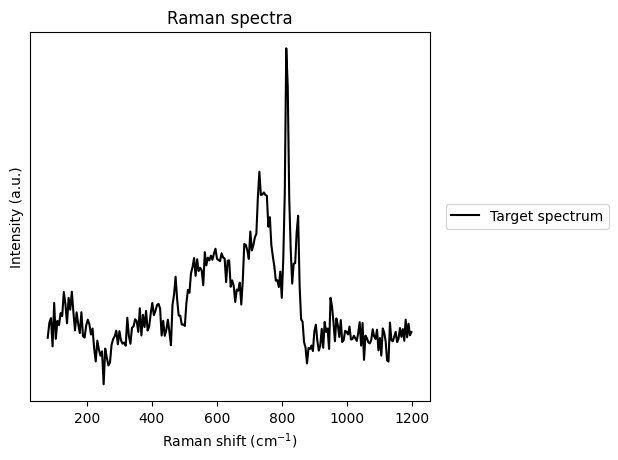

In [12]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def spectral_similarity(spec1, spec2):
    # Interpolate the spectra to have the same spectral axis
    interpolated_spec2 = np.interp(spec1.spectral_axis, spec2.spectral_axis, spec2.spectral_data)
    # Calculate the Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(spec1.spectral_data, interpolated_spec2)
    return correlation_coefficient

database=local_rruff_pp
N=5
similarity_scores = []
for index, spectrum in enumerate(database[0]):
    similarity = spectral_similarity(target_spec_preprocessed, spectrum)
    similarity_scores.append((index, similarity))

similarity_scores.sort(key=lambda x: x[1], reverse=True)
top_matches = similarity_scores[:N]


rp.plot.spectra([database[0][index] for index,_ in top_matches], 
                label=[database[1][index]['##NAMES']+f", {similarity*100:.1f}% match" for index,similarity in top_matches], 
                plot_type='single stacked')

rp.plot.spectra(target_spec_preprocessed, label="Target spectrum", color='k')


## Get RRUFF and preprocess

In [14]:
fur=rp.datasets.rruff('fair_unoriented')
local_rruff_pp=(preprocessing_pipeline.apply(fur[0]),fur[1].copy())

c:\Users\charl\anaconda3\envs\py3115\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\charl\anaconda3\envs\py3115\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LinAlgError: 731th leading minor not positive definite

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

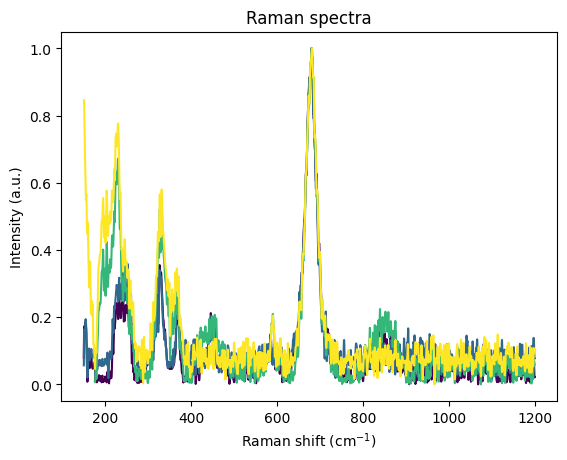

In [ ]:
ilmenite_indices = []

for index, item in enumerate(fur_pp[1]):
    if 'ilmenite' in item['##NAMES'].lower():
        ilmenite_indices.append(index)

ilmenite=([fur_pp[0][index] for index in ilmenite_indices],[fur_pp[1][index] for index in ilmenite_indices])

rp.plot.spectra(ilmenite[0],plot_type='single')

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

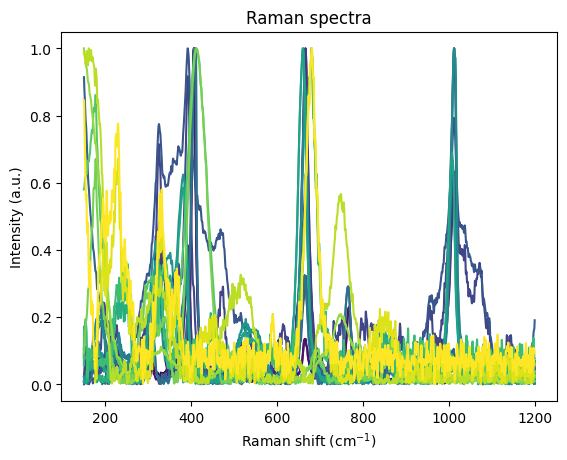

In [ ]:
substrings_to_search = ['ilmenite', 'olivine', 'diopside', 'spinel']
fur_sub_indices = []

for index, item in enumerate(fur_pp[1]):
    for substring in substrings_to_search:
        if substring in item['##NAMES'].lower():
            fur_sub_indices.append(index)
            break  # Break out of the inner loop if a match is found to avoid duplicate indices

fur_sub = ([fur_pp[0][index] for index in fur_sub_indices], [fur_pp[1][index] for index in fur_sub_indices])

rp.plot.spectra(fur_sub[0],plot_type='single')

Best matching spectrum index: 736
Best similarity: 0.8707169807485857


<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

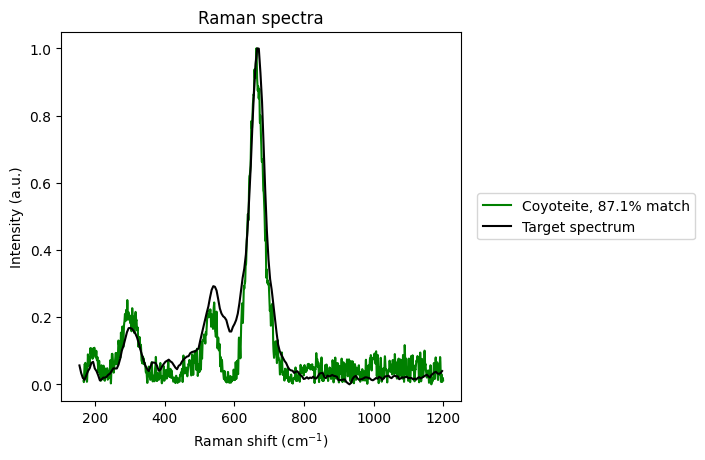

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def spectral_similarity(spec1, spec2):
    # Interpolate the spectra to have the same spectral axis
    interpolated_spec2 = np.interp(spec1.spectral_axis, spec2.spectral_axis, spec2.spectral_data)
    # Calculate the Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(spec1.spectral_data, interpolated_spec2)
    return correlation_coefficient

# Initialize variables to store the best match
best_match_index = None
best_similarity = -np.inf

# Iterate over spectra in database[0] and find the best match
database=fur_pp

for index, spectrum in enumerate(database[0]):
    similarity = spectral_similarity(target_spec, spectrum)
    if similarity > best_similarity:
        best_similarity = similarity
        best_match_index = index

print("Best matching spectrum index:", best_match_index)
print("Best similarity:", best_similarity)

rp.plot.spectra(database[0][best_match_index],plot_type='single',title="Best match spectrum",
                label=database[1][best_match_index]['##NAMES']+f", {best_similarity*100:.1f}% match",color='g')
rp.plot.spectra(target_spec_preprocessed,label="Target spectrum",color='k')




Xray package rabernat github. 
